[link text](https://)  
# Co + OS + Camping Combined Training

## Setup

In [154]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
import numpy as np
import typing
from typing import Any, Tuple
from sklearn.model_selection import train_test_split

import pathlib

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [156]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

#### Loading the Dataset

In [170]:
import pandas as pd
ORM_data = pd.read_csv('CO_OS_Mapping.csv')


In [171]:
ORM_data.head()

,OM_Regular,OM_Prediction
0,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...
1,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...
2,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...
3,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...
4,moduleOM_name:0openDeclarationonesigclass1_nam...,moduleOM_name:0openDeclarationonesigclass1_nam...


In [172]:
OM_Regular = ORM_data['OM_Regular'].values
OM_Prediction = ORM_data['OM_Prediction'].values

In [173]:
X = OM_Regular
Y = OM_Prediction

#### Dividing data as Target and Context

In [174]:
target_raw =  Y
context_raw = X
print(context_raw[-1])

moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparenti

In [175]:
print(target_raw[-1])

moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparenti

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [176]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 1

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [177]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor([b'moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_a

### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation, We may or may not decide to Use this for ORM data. I kept it in the experiment

In [178]:
example_text = tf.constant('moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSe=c1_a+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_nameAssociationTableassoc1Destination:class2_nameOneToManyAssociationSource>DestinationMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass3_name:map_str3AssociationMappingStrategy:ForeignKeyEmbedding,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_type,KEY`FK_class2_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`orderID`)Tablestructurefortableclass3_nameCREATETABLE`class3_name``c3_at1`int`c1_at1`c1_at1_typeNOTNULLKEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at2`c1_at2_type`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE ')
#example_text = tf.constant('module OM_name open Declaration one sig class1_name extends Class attrSet = c1_at1+c1_at2 id=c1_at1 no parent isAbstract = No } one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class attrSet = c2_at1+c2_at2+c2_at3+c2_at4 id=c2_at1 no parent isAbstract = No } one sig c2_at1 extends c2_at1_type one sig c2_at2 extends c2_at2_type one sig c2_at3 extends c2_at3_type one sig c2_at4 extends c2_at4_type one sig class3_name extends Class attrSet = c3_at1+c3_at2+c3_at3+c3_at4 id=c3_at1 no parent isAbstract = No } one sig c3_at1 extends c3_at1_type one sig c3_at2 extends c3_at2_type one sig c3_at3 extends c3_at3_type one sig c3_at4 extends c3_at4_type one sig class4_name extends Class attrSet = c4_at1 id=c4_at1 no parent isAbstract = No } one sig c4_at1 extends c4_at1_type one sig class5_name extends Class attrSet = c5_at1+c5_at2+c5_at3+c5_at4 id=c5_at1 no parent isAbstract = No } one sig c5_at1 extends c5_at1_type one sig c5_at2 extends c5_at2_type one sig c5_at3 extends c5_at3_type one sig c5_at4 extends c5_at4_type one sig class6_name extends Class attrSet = c6_at1+c6_at2+c6_at3+c6_at4 id=c6_at1 no parent isAbstract = No } one sig c6_at1 extends c6_at1_type one sig c6_at2 extends c6_at2_type one sig c6_at3 extends c6_at3_type one sig c6_at4 extends c6_at4_type one sig assoc1 extends Association src = class1_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc2 extends Association src = class1_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc3 extends Association src = class4_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc4 extends Association src = class1_name dst= class6_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc2 } one sig assoc5 extends Association src = class1_name dst= class3_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc2 } pred show run show for 38, Enter File Name to Generate Abstract: sol8.txt OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at1: c1_at1_type Primary Key Table: class2_name Attribute c2_at2: c2_at2_type Table: class2_name Attribute c2_at3: c2_at3_type Table: class3_name Attribute c3_at1: c3_at1_type Primary Key Table: class3_name Attribute c3_at4: c3_at4_type Table: class3_name Attribute c3_at2: c3_at2_type Table: class4_name Attribute c4_at1: c4_at1_type Primary Key Table: class5_name Attribute c5_at3: c5_at3_type Table: class5_name Attribute c5_at4: c5_at4_type Table: class6_name Attribute c6_at1: c6_at1_type Primary Key Table: class6_name Attribute c6_at2: c6_at2_type Table: class6_name Attribute c6_at3: c6_at3_type Table: class6_name Attribute c6_at4: c6_at4_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class2_name Attribute c2_at1: c1_at1_type Primary Key Table: class3_name Attribute c3_at1: c3_at1_type Primary Key Table: class4_name Attribute c4_at1: c4_at1_type Primary Key Table: class6_name Attribute c6_at1: c6_at1_type Primary Key Table Name: class1_name Table Name: class2_name Table Name: class3_name Table Name: class4_name Table Name: class5_name Table Name: class6_name Mapping Strategy of Table class1_name: map_str2 Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class3_name: map_str2 Mapping Strategy of Table class4_name: map_str2 Mapping Strategy of Table class6_name: map_str2 Association Strategy for assoc2 : assoc_type1 Association Strategy for assoc1 : assoc_type2 Association Strategy for assoc3 : assoc_type2 Association Strategy for assoc4 : assoc_type2 Association Strategy for assoc5 : assoc_type2, USE OM_name0 -- -- CREATE TABLE `assoc1` ( `c5_at1` c5_at1_type, `c1_at1` c1_at1_type, KEY `FK_assoc1_c5_at1_idx` (`c5_at1`), KEY `FK_assoc1_c1_at1_idx` (`c1_at1`), PRIMARY KEY (`c5_at1`,`c1_at1`) ); -- -- CREATE TABLE `assoc3` `c5_at1` c5_at1_type, `c4_at1` c4_at1_type, KEY `FK_assoc3_c5_at1_idx` (`c5_at1`), KEY `FK_assoc3_c4_at1_idx` (`c4_at1`), PRIMARY KEY (`c5_at1`,`c4_at1`) ); -- -- CREATE TABLE `class5_name` ( `c5_at4` c5_at4_type(64) `c5_at3` c5_at3_type(64) `c1_at1` c1_at1_type, `c5_at1` c5_at1_type, `c2_at1` c2_at1_type, FK_class5_name_c2_at1_idx` (`c2_at1`), PRIMARY KEY (`c5_at1`) ); -- -- CREATE TABLE `class3_name` ( `c3_at3` c3_at3_type(64) `c3_at2` c3_at2_type(64) `c3_at4` c3_at4_type, `c3_at1` c3_at1_type NOT NULL, PRIMARY KEY (`c3_at1`) ); -- -- CREATE TABLE `class2_name` ( `c2_at3` c2_at3_type(64) `c2_at2` c2_at2_type(64) `c2_at4` c2_at4_type, `c2_at1` c2_at1_type, PRIMARY KEY (`c2_at1`) ); -- -- CREATE TABLE `class4_name` ( `c4_at1` c4_at1_type, PRIMARY KEY (`c4_at1`) ); -- -- CREATE TABLE `class1_name` ( `c1_at2` c1_at2_type(64) `c1_at1` c1_at1_type, PRIMARY KEY (`c1_at1`) ); -- -- CREATE TABLE `assoc5` ( `c3_at1` c3_at1_type NOT NULL, `c2_at1` c2_at1_type, KEY `FK_assoc5_c3_at1_idx` (`c3_at1`), KEY `FK_assoc5_c2_at1_idx` (`c2_at1`), PRIMARY KEY (`c3_at1`,`c2_at1`) ); -- -- CREATE TABLE `class6_name` ( `c6_at4` c6_at4_type, `c6_at3` c6_at3_type, `c6_at2` c6_at2_type, `c6_at1` c6_at1_type NOT NULL, PRIMARY KEY (`c6_at1`) ); -- -- CREATE TABLE `assoc4` ( `c6_at1` c6_at1_type NOT NULL, `c2_at1` c2_at1_type, KEY `FK_assoc4_c6_at1_idx` (`c6_at1`), KEY `FK_assoc4_c2_at1_idx` (`c2_at1`), PRIMARY KEY (`c6_at1`,`c2_at1`) ); ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c5_at1` FOREIGN KEY (`c5_at1`) REFERENCES `class5_name` (`c5_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc3` ADD CONSTRAINT `FK_assoc3_c5_at1` FOREIGN KEY (`c5_at1`) REFERENCES `class5_name` (`c5_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc3_c4_at1` FOREIGN KEY (`c4_at1`) REFERENCES `class4_name` (`c4_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `class5_name` ADD CONSTRAINT `FK_class5_name_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc5` ADD CONSTRAINT `FK_assoc5_c3_at1` FOREIGN KEY (`c3_at1`) REFERENCES `class3_name` (`c3_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc5_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc4` ADD CONSTRAINT `FK_assoc4_c6_at1` FOREIGN KEY (`c6_at1`) REFERENCES `class6_name` (`c6_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc4_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSe=c1_a+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_

In [179]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '', r'')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [180]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSe=c1_a+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_na

#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [181]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [182]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'moduleom_nameonesigclass1_nameextendsclassattrset=c1_at1+c1_at2attrset=c1_at1+c1_at2isabstract=nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassid=integerisabstract=nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsassociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsclassattrset=c3_at1oneparentparentinclass1_nameisabstract=noattrset=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,om_name_solution:0table:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class1_nameattributec1_at2:c1_at2_typetable:class2_nameattributec2_at2:c1_at2_typetable:class3_nameattributec3_at1:c3_at1_typetable:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class3_nameattributec1_at1:c1_at1_typeforeignkeytable:class3_nameparentclassclass1_nametablename:class1_nametablename:class2_nametablename:class3_

That's the context data  `TextVectorization` layer, now build and `.adapt()` for the Target Data one:

In [183]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'moduleom_nameonesigclass1_nameextendsclassattrset=c1_at1+c1_at2attrset=c1_at1+c1_at2isabstract=nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassid=integerisabstract=nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsassociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsclassattrset=c3_at1oneparentparentinclass1_nameisabstract=noattrset=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,om_name_solution:0table:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class1_nameattributec1_at2:c1_at2_typetable:class2_nameattributec2_at2:c1_at2_typetable:class3_nameattributec3_at1:c3_at1_typetable:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class3_nameattributec1_at1:c1_at1_typeforeignkeytable:class3_nameparentclassclass1_nametablename:class1_nametablename:class2_nametablename:class3_

Now these layers can convert a batch of strings into a batch of token IDs:

In [184]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 36, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [185]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3ex

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

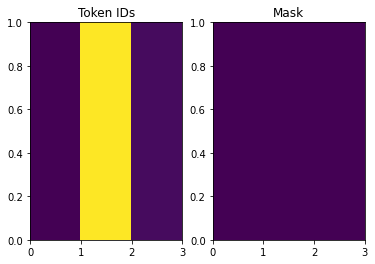

In [187]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [188]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [189]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2 145   3]

[  2 149]
[149   3]


## The encoder/decoder

  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [190]:
UNITS = 256

### The encoder


The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [191]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [192]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (1, 3)
Encoder output, shape (batch, s, units): (1, 3, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 


In [193]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [194]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (1, 3, 256)
Target sequence, shape (batch, t, units): (1, 2, 256)
Attention result, shape (batch, t, units): (1, 2, 256)
Attention weights, shape (batch, t, s):    (1, 2, 3)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [197]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1.], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

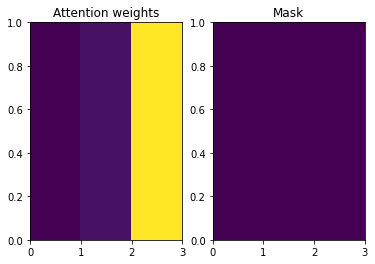

In [198]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.


Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [199]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [200]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [201]:
decoder = Decoder(target_text_processor, UNITS)

Decoder usage

In [202]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (1, 3, 256)
input target tokens shape: (batch, t) (1, 2)
logits shape shape: (batch, target_vocabulary_size) (1, 2, 179)


#### Inference

For inference usage couple more methods.

In [203]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [204]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [205]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [206]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3ex



```
# This is formatted as code
```

**Since the model's untrained, it outputs items from the vocabulary almost uniformly at random. **

## The model


In [207]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [208]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (1, 3)
Target tokens, shape: (batch, t) (1, 2)
logits, shape: (batch, t, target_vocabulary_size) (1, 2, 179)


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [209]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [210]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [211]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [253]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 5.187386, 'expected_acc': 0.00558659217877095}

That should roughly match the values returned by running a few steps of evaluation:

In [254]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 0s 12ms/step - loss: 4.5620 - masked_acc: 0.6750 - masked_loss: 4.5620


{'loss': 4.561983585357666,
 'masked_acc': 0.675000011920929,
 'masked_loss': 4.561983585357666}

In [255]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 6s 58ms/step - loss: 0.2458 - masked_acc: 0.9500 - masked_loss: 0.2458 - val_loss: 3.9966 - val_masked_acc: 0.7250 - val_masked_loss: 3.9966
Epoch 2/100
100/100 [==============================] - 4s 43ms/step - loss: 0.3604 - masked_acc: 0.9050 - masked_loss: 0.3604 - val_loss: 3.9266 - val_masked_acc: 0.7250 - val_masked_loss: 3.9266
Epoch 3/100
100/100 [==============================] - 4s 43ms/step - loss: 0.1964 - masked_acc: 0.9700 - masked_loss: 0.1964 - val_loss: 4.0547 - val_masked_acc: 0.7000 - val_masked_loss: 4.0547
Epoch 4/100
100/100 [==============================] - 4s 43ms/step - loss: 0.1605 - masked_acc: 0.9750 - masked_loss: 0.1605 - val_loss: 3.7501 - val_masked_acc: 0.7500 - val_masked_loss: 3.7501
Epoch 5/100
100/100 [==============================] - 4s 42ms/step - loss: 0.1979 - masked_acc: 0.9600 - masked_loss: 0.1979 - val_loss: 4.3520 - val_masked_acc: 0.7000 - val_masked_loss: 4.3520
Epoch 6/100
100/100 

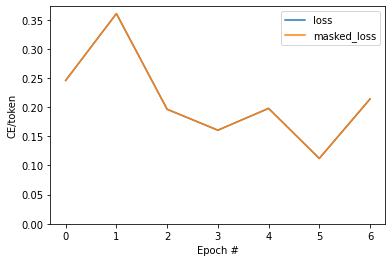

In [256]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['masked_loss'], label='masked_loss')
#plt.plot(history.history['val_masked_loss'], label='val_masked_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

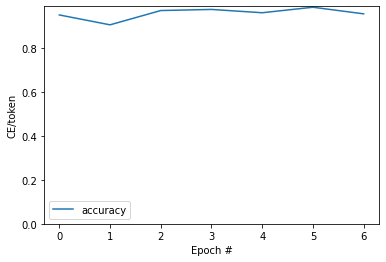

In [257]:
plt.plot(history.history['masked_acc'], label='accuracy')
#plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [258]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [259]:

#With Spaces 

#Customer Order Unseen 
#NP 
result00 = model.translate(['module OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16,OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`c2_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at3` c1_at3_type(64) `c1_at2` c1_at2_type `c3_at1` int `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])
result001 = model.translate(['odule OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16,OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`c2_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at3` c1_at3_type(64) `c1_at2` c1_at2_type `c3_at1` int `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE '])
#P
result002 = model.translate(['module OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16, OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`orderID`) Table structure for table class3_name CREATE TABLE `class3_name` `c3_at1` int `c1_at1` c1_at1_type NOT NULL KEY `FK_class3_name_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at2` c1_at2_type `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `class3_name` ADD CONSTRAINT `FK_class3_name_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])
result004 = model.translate(['module OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16, OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`orderID`) Table structure for table class3_name CREATE TABLE `class3_name` `c3_at1` int `c1_at1` c1_at1_type NOT NULL KEY `FK_class3_name_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at2` c1_at2_type `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `class3_name` ADD CONSTRAINT `FK_class3_name_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])

#Online Store Unseen 

#P 

result005 = model.translate(['module OM_name open Declaration one sig class1_name extends Class attrSet = c1_at1+c1_at2 id=c1_at1 no parent isAbstract = No } one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class attrSet = c2_at1+c2_at2+c2_at3+c2_at4 id=c2_at1 no parent isAbstract = No } one sig c2_at1 extends c2_at1_type one sig c2_at2 extends c2_at2_type one sig c2_at3 extends c2_at3_type one sig c2_at4 extends c2_at4_type one sig class3_name extends Class attrSet = c3_at1+c3_at2+c3_at3+c3_at4 id=c3_at1 no parent isAbstract = No } one sig c3_at1 extends c3_at1_type one sig c3_at2 extends c3_at2_type one sig c3_at3 extends c3_at3_type one sig c3_at4 extends c3_at4_type one sig class4_name extends Class attrSet = c4_at1 id=c4_at1 no parent isAbstract = No } one sig c4_at1 extends c4_at1_type one sig class5_name extends Class attrSet = c5_at1+c5_at2+c5_at3+c5_at4 id=c5_at1 no parent isAbstract = No } one sig c5_at1 extends c5_at1_type one sig c5_at2 extends c5_at2_type one sig c5_at3 extends c5_at3_type one sig c5_at4 extends c5_at4_type one sig class6_name extends Class attrSet = c6_at1+c6_at2+c6_at3+c6_at4 id=c6_at1 no parent isAbstract = No } one sig c6_at1 extends c6_at1_type one sig c6_at2 extends c6_at2_type one sig c6_at3 extends c6_at3_type one sig c6_at4 extends c6_at4_type one sig assoc1 extends Association src = class1_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc2 extends Association src = class1_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc3 extends Association src = class4_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc4 extends Association src = class1_name dst= class6_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc2 } one sig assoc5 extends Association src = class1_name dst= class3_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc2 } pred show run show for 38, OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at1: c1_at1_type Primary Key Table: class2_name Attribute c2_at2: c2_at2_type Table: class2_name Attribute c2_at3: c2_at3_type Table: class3_name Attribute c3_at1: c3_at1_type Primary Key Table: class3_name Attribute c3_at4: c3_at4_type Table: class3_name Attribute c3_at2: c3_at2_type Table: class4_name Attribute c4_at1: c4_at1_type Primary Key Table: class5_name Attribute c5_at3: c5_at3_type Table: class5_name Attribute c5_at4: c5_at4_type Table: class6_name Attribute c6_at1: c6_at1_type Primary Key Table: class6_name Attribute c6_at2: c6_at2_type Table: class6_name Attribute c6_at3: c6_at3_type Table: class6_name Attribute c6_at4: c6_at4_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class2_name Attribute c2_at1: c1_at1_type Primary Key Table: class3_name Attribute c3_at1: c3_at1_type Primary Key Table: class4_name Attribute c4_at1: c4_at1_type Primary Key Table: class6_name Attribute c6_at1: c6_at1_type Primary Key Table Name: class1_name Table Name: class2_name Table Name: class3_name Table Name: class4_name Table Name: class5_name Table Name: class6_name Mapping Strategy of Table class1_name: map_str2 Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class3_name: map_str2 Mapping Strategy of Table class4_name: map_str2 Mapping Strategy of Table class6_name: map_str2 Association Strategy for assoc1 : assoc_type1 Association Strategy for assoc2 : assoc_type1 Association Strategy for assoc3 : assoc_type2 Association Strategy for assoc4 : assoc_type2 Association Strategy for assoc5 : assoc_type2, USE OM_name0 -- -- CREATE TABLE `assoc3` `c5_at1` c5_at1_type, `c4_at1` c4_at1_type, KEY `FK_assoc3_c5_at1_idx` (`c5_at1`), KEY `FK_ProductsGuestAssociation_GuestId_idx` (`GuestId`), PRIMARY KEY (`ProductsId`,`GuestId`) ); -- -- CREATE TABLE `class5_name` ( `c5_at4` c5_at4_type(64) `c5_at3` c5_at3_type(64) `c1_at1` c1_at1_type, `c5_at1` c5_at1_type, `c2_at1` c2_at1_type, `c1_at1` c1_at1_type, FK_class5_name_c2_at1_idx` (`c2_at1`), FK_class5_name_c1_at1_idx` (`c1_at1`), PRIMARY KEY (`c5_at1`) ); -- -- CREATE TABLE `class3_name` ( `c3_at3` c3_at3_type(64) `c3_at2` c3_at2_type(64) `c3_at4` c3_at4_type, `c3_at1` c3_at1_type NOT NULL, PRIMARY KEY (`c3_at1`) ); -- -- CREATE TABLE `class2_name` ( `c2_at3` c2_at3_type(64) `c2_at2` c2_at2_type(64) `c2_at4` c2_at4_type, `c2_at1` c2_at1_type, PRIMARY KEY (`c2_at1`) ); -- -- CREATE TABLE `class4_name` ( `c4_at1` c4_at1_type, PRIMARY KEY (`c4_at1`) ); -- -- CREATE TABLE `class1_name` ( `c1_at2` c1_at2_type(64) `c1_at1` c1_at1_type, PRIMARY KEY (`c1_at1`) ); -- -- CREATE TABLE `assoc5` ( `c3_at1` c3_at1_type NOT NULL, `c2_at1` c2_at1_type, KEY `FK_assoc5_c3_at1_idx` (`c3_at1`), KEY `FK_assoc5_c2_at1_idx` (`c2_at1`), PRIMARY KEY (`c3_at1`,`c2_at1`) ); -- -- CREATE TABLE `assoc4` ( `c6_at1` c6_at1_type NOT NULL, `c2_at1` c2_at1_type, KEY `FK_assoc4_c6_at1_idx` (`c6_at1`), KEY `FK_assoc4_c2_at1_idx` (`c2_at1`), PRIMARY KEY (`c6_at1`,`c2_at1`) ); -- -- CREATE TABLE `class6_name` ( `c6_at4` c6_at4_type, `c6_at3` c6_at3_type, `c6_at2` c6_at2_type, `c6_at1` c6_at1_type NOT NULL, PRIMARY KEY (`c6_at1`) ); ALTER TABLE `assoc3` ADD CONSTRAINT `FK_assoc3_c5_at1` FOREIGN KEY (`c5_at1`) REFERENCES `class5_name` (`c5_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc3_c4_at1` FOREIGN KEY (`c4_at1`) REFERENCES `class4_name` (`c4_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `class5_name` ADD CONSTRAINT `FK_class5_name_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_class5_name_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc5` ADD CONSTRAINT `FK_assoc5_c3_at1` FOREIGN KEY (`c3_at1`) REFERENCES `class3_name` (`c3_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc5_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc4` ADD CONSTRAINT `FK_assoc4_c6_at1` FOREIGN KEY (`c6_at1`) REFERENCES `class6_name` (`c6_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc4_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])


#Without spaces 

#unseen data customer order OM 

#NP 
result = model.translate(['module OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16,OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`c2_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at3` c1_at3_type(64) `c1_at2` c1_at2_type `c3_at1` int `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])
result5 = model.translate(['odule OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16,OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`c2_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at3` c1_at3_type(64) `c1_at2` c1_at2_type `c3_at1` int `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE '])
#P
result2 = model.translate(['module OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16, OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`orderID`) Table structure for table class3_name CREATE TABLE `class3_name` `c3_at1` int `c1_at1` c1_at1_type NOT NULL KEY `FK_class3_name_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at2` c1_at2_type `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `class3_name` ADD CONSTRAINT `FK_class3_name_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])
result4 = model.translate(['module OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16, OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`orderID`) Table structure for table class3_name CREATE TABLE `class3_name` `c3_at1` int `c1_at1` c1_at1_type NOT NULL KEY `FK_class3_name_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at2` c1_at2_type `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `class3_name` ADD CONSTRAINT `FK_class3_name_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])

#From Dataset Customer Order 
#P
result3 = model.translate(['moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSet=c1_at1+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16.OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_nameAssociationTableassoc1Destination:class2_nameOneToManyAssociationSource>DestinationMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str3AssociationMappingStrategy:OwnAssociationTable,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`orderID`)Tablestructurefortableclass3_nameCREATETABLE`class3_name``c1_at2`c1_at2_type`c3_at1`int`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at2`c1_at2_type`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`assoc1``c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULLKEY`FK_assoc1_c2_at1_idx`(`c2_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c2_at1`,`c1_at1`)ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE'])

#unseen data online store OM
result32 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc2:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_type,`c2_at1`c2_at1_type,`c1_at1`c1_at1_type,FK_class5_name_c4_at1_idx`(`c4_at1`),FK_class5_name_c2_at1_idx`(`c2_at1`),FK_class5_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result33 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,EnterFileNametoGenerateAbstract:sol1.txtOM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type,`c1_at1`c1_at1_type,KEY`FK_assoc1_c5_at1_idx`(`c5_at1`),KEY`FK_assoc1_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`,`c1_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_type,FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type,`c2_at1`c2_at1_type,KEY`FK_assoc2_c5_at1_idx`(`c5_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c5_at1`,`c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_Products_GuestId`FOREIGNKEY(`GuestId`)REFERENCES`Guest`(`GuestId`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])

#NP 
result31 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,EnterFileNametoGenerateAbstract:sol1.txtOM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type,`c1_at1`c1_at1_type,KEY`FK_assoc1_c5_at1_idx`(`c5_at1`),KEY`FK_assoc1_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`,`c1_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_type,FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type,`c2_at1`c2_at1_type,KEY`FK_assoc2_c5_at1_idx`(`c5_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c5_at1`,`c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_Products_GuestId`FOREIGNKEY(`GuestId`)REFERENCES`Guest`(`GuestId`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result34 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc3``c5_at1`c5_at1_type,`c4_at1`c4_at1_type,KEY`FK_assoc3_c5_at1_idx`(`c5_at1`),KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c5_at1`,`c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c1_at1`c1_at1_type,FK_class5_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type,`c2_at1`c2_at1_type,KEY`FK_assoc2_c5_at1_idx`(`c5_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c5_at1`,`c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result35 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc3``c5_at1`c5_at1_type,`c4_at1`c4_at1_type,KEY`FK_assoc3_c5_at1_idx`(`c5_at1`),KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c5_at1`,`c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c1_at1`c1_at1_type,FK_class5_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type,`c2_at1`c2_at1_type,KEY`FK_assoc2_c5_at1_idx`(`c5_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c5_at1`,`c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result38 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38​,EnterFileNametoGenerateAbstract:sol8.txtOM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type,`c1_at1`c1_at1_type,KEY`FK_assoc1_c5_at1_idx`(`c5_at1`),KEY`FK_assoc1_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`,`c1_at1`));----CREATETABLE`assoc3``c5_at1`c5_at1_type,`c4_at1`c4_at1_type,KEY`FK_assoc3_c5_at1_idx`(`c5_at1`),KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c5_at1`,`c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type,`c2_at1`c2_at1_type,KEY`FK_assoc2_c5_at1_idx`(`c5_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c5_at1`,`c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
#P 
result28 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc2:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_type,`c2_at1`c2_at1_type,`c1_at1`c1_at1_type,FK_class5_name_c4_at1_idx`(`c4_at1`),FK_class5_name_c2_at1_idx`(`c2_at1`),FK_class5_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result20 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc2:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type,`c1_at1`c1_at1_type,KEY`FK_assoc1_c5_at1_idx`(`c5_at1`),KEY`FK_assoc1_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`,`c1_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_type,`c2_at1`c2_at1_type,FK_class5_name_c4_at1_idx`(`c4_at1`),FK_class5_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result21 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc3``c5_at1`c5_at1_type,`c4_at1`c4_at1_type,KEY`FK_assoc3_c5_at1_idx`(`c5_at1`),KEY`FK_ProductsGuestAssociation_GuestId_idx`(`GuestId`),PRIMARYKEY(`ProductsId`,`GuestId`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c2_at1`c2_at1_type,`c1_at1`c1_at1_type,FK_class5_name_c2_at1_idx`(`c2_at1`),FK_class5_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
#From Dataset Online Store

#P 
result44 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,EnterFileNametoGenerateAbstract:sol8.txtOM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_type,`c2_at1`c2_at1_type,`c1_at1`c1_at1_type,FK_class5_name_c4_at1_idx`(`c4_at1`),FK_class5_name_c2_at1_idx`(`c2_at1`),FK_class5_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result45 = model.translate(['module OM_name open Declaration one sig class1_name extends Class attrSet = c1_at1+c1_at2 id=c1_at1 no parent isAbstract = No } one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class attrSet = c2_at1+c2_at2+c2_at3+c2_at4 id=c2_at1 no parent isAbstract = No } one sig c2_at1 extends c2_at1_type one sig c2_at2 extends c2_at2_type one sig c2_at3 extends c2_at3_type one sig c2_at4 extends c2_at4_type one sig class3_name extends Class attrSet = c3_at1+c3_at2+c3_at3+c3_at4 id=c3_at1 no parent isAbstract = No } one sig c3_at1 extends c3_at1_type one sig c3_at2 extends c3_at2_type one sig c3_at3 extends c3_at3_type one sig c3_at4 extends c3_at4_type one sig class4_name extends Class attrSet = c4_at1 id=c4_at1 no parent isAbstract = No } one sig c4_at1 extends c4_at1_type one sig class5_name extends Class attrSet = c5_at1+c5_at2+c5_at3+c5_at4 id=c5_at1 no parent isAbstract = No } one sig c5_at1 extends c5_at1_type one sig c5_at2 extends c5_at2_type one sig c5_at3 extends c5_at3_type one sig c5_at4 extends c5_at4_type one sig class6_name extends Class attrSet = c6_at1+c6_at2+c6_at3+c6_at4 id=c6_at1 no parent isAbstract = No } one sig c6_at1 extends c6_at1_type one sig c6_at2 extends c6_at2_type one sig c6_at3 extends c6_at3_type one sig c6_at4 extends c6_at4_type one sig assoc1 extends Association src = class1_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc2 extends Association src = class1_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc3 extends Association src = class4_name dst= class5_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc } one sig assoc4 extends Association src = class1_name dst= class6_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc2 } one sig assoc5 extends Association src = class1_name dst= class3_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc2 } pred show run show for 38 , Abstract: sol1.txt OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at1: c1_at1_type Primary Key Table: class2_name Attribute c2_at2: c2_at2_type Table: class2_name Attribute c2_at3: c2_at3_type Table: class3_name Attribute c3_at1: c3_at1_type Primary Key Table: class3_name Attribute c3_at4: c3_at4_type Table: class3_name Attribute c3_at2: c3_at2_type Table: class4_name Attribute c4_at1: c4_at1_type Primary Key Table: class5_name Attribute c5_at3: c5_at3_type Table: class5_name Attribute c5_at4: c5_at4_type Table: class6_name Attribute c6_at1: c6_at1_type Primary Key Table: class6_name Attribute c6_at2: c6_at2_type Table: class6_name Attribute c6_at3: c6_at3_type Table: class6_name Attribute c6_at4: c6_at4_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class2_name Attribute c2_at1: c1_at1_type Primary Key Table: class3_name Attribute c3_at1: c3_at1_type Primary Key Table: class4_name Attribute c4_at1: c4_at1_type Primary Key Table: class6_name Attribute c6_at1: c6_at1_type Primary Key Table Name: class1_name Table Name: class2_name Table Name: class3_name Table Name: class4_name Table Name: class5_name Table Name: class6_name Mapping Strategy of Table class1_name: map_str2 Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class3_name: map_str2 Mapping Strategy of Table class4_name: map_str2 Mapping Strategy of Table class6_name: map_str2 Association Strategy for assoc1 : assoc_type1 Association Strategy for assoc2 : assoc_type1 Association Strategy for assoc3 : assoc_type1 Association Strategy for assoc4 : assoc_type2 Association Strategy for assoc5 : assoc_type2, USE OM_name0 -- -- CREATE TABLE `class5_name` ( `c5_at4` c5_at4_type(64) `c5_at3` c5_at3_type(64) `c1_at1` c1_at1_type, `c5_at1` c5_at1_type, `c4_at1` c4_at1_type, `c2_at1` c2_at1_type, `c1_at1` c1_at1_type, FK_class5_name_c4_at1_idx` (`c4_at1`), FK_class5_name_c2_at1_idx` (`c2_at1`), FK_class5_name_c1_at1_idx` (`c1_at1`), PRIMARY KEY (`c5_at1`) ); -- -- CREATE TABLE `class3_name` ( `c3_at3` c3_at3_type(64) `c3_at2` c3_at2_type(64) `c3_at4` c3_at4_type, `c3_at1` c3_at1_type NOT NULL, PRIMARY KEY (`c3_at1`) ); -- -- CREATE TABLE `class2_name` ( `c2_at3` c2_at3_type(64) `c2_at2` c2_at2_type(64) `c2_at4` c2_at4_type, `c2_at1` c2_at1_type, PRIMARY KEY (`c2_at1`) ); -- -- CREATE TABLE `class4_name` ( `c4_at1` c4_at1_type, PRIMARY KEY (`c4_at1`) ); -- -- CREATE TABLE `class1_name` ( `c1_at2` c1_at2_type(64) `c1_at1` c1_at1_type, PRIMARY KEY (`c1_at1`) ); -- -- CREATE TABLE `assoc5` ( `c3_at1` c3_at1_type NOT NULL, `c2_at1` c2_at1_type, KEY `FK_assoc5_c3_at1_idx` (`c3_at1`), KEY `FK_assoc5_c2_at1_idx` (`c2_at1`), PRIMARY KEY (`c3_at1`,`c2_at1`) ); -- -- CREATE TABLE `class6_name` ( `c6_at4` c6_at4_type, `c6_at3` c6_at3_type, `c6_at2` c6_at2_type, `c6_at1` c6_at1_type NOT NULL, PRIMARY KEY (`c6_at1`) ); -- -- CREATE TABLE `assoc4` ( `c6_at1` c6_at1_type NOT NULL, `c2_at1` c2_at1_type, KEY `FK_assoc4_c6_at1_idx` (`c6_at1`), KEY `FK_assoc4_c2_at1_idx` (`c2_at1`), PRIMARY KEY (`c6_at1`,`c2_at1`) ); ALTER TABLE `class5_name` ADD CONSTRAINT `FK_class5_name_c4_at1` FOREIGN KEY (`c4_at1`) REFERENCES `class4_name` (`c4_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_class5_name_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_class5_name_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc5` ADD CONSTRAINT `FK_assoc5_c3_at1` FOREIGN KEY (`c3_at1`) REFERENCES `class3_name` (`c3_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc5_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE; ALTER TABLE `assoc4` ADD CONSTRAINT `FK_assoc4_c6_at1` FOREIGN KEY (`c6_at1`) REFERENCES `class6_name` (`c6_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc4_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])

#NP
result36 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc3``c5_at1`c5_at1_type,`c4_at1`c4_at1_type,KEY`FK_assoc3_c5_at1_idx`(`c5_at1`),KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c5_at1`,`c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c1_at1`c1_at1_type,FK_class5_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type,`c2_at1`c2_at1_type,KEY`FK_assoc2_c5_at1_idx`(`c5_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c5_at1`,`c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result37 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,EnterFileNametoGenerateAbstract:sol8.txtOM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_type,`c2_at1`c2_at1_type,`c1_at1`c1_at1_type,FK_class5_name_c4_at1_idx`(`c4_at1`),FK_class5_name_c2_at1_idx`(`c2_at1`),FK_class5_name_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class5_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])

result39 = model.translate(['moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type,`c1_at1`c1_at1_type,KEY`FK_assoc1_c5_at1_idx`(`c5_at1`),KEY`FK_assoc1_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c5_at1`,`c1_at1`));----CREATETABLE`assoc3``c5_at1`c5_at1_type,`c4_at1`c4_at1_type,KEY`FK_assoc3_c5_at1_idx`(`c5_at1`),KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c5_at1`,`c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type,`c5_at1`c5_at1_type,PRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type,`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type,`c2_at1`c2_at1_type,PRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_type,PRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_type,PRIMARYKEY(`c1_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type,`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type,`c2_at1`c2_at1_type,KEY`FK_assoc2_c5_at1_idx`(`c5_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c5_at1`,`c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc5_c3_at1_idx`(`c3_at1`),KEY`FK_assoc5_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c3_at1`,`c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_assoc4_c6_at1_idx`(`c6_at1`),KEY`FK_assoc4_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])

result005[0].numpy().decode()




'moduleom_nameopendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsclassattrset=c4_at1id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparent

In [266]:
result00 = model.translate(['module OM_name one sig class1_name extends Class attrSet = c1_at1+c1_at2 attrSet = c1_at1+c1_at2 isAbstract = No no parent one sig c1_at1 extends c1_at1_type one sig c1_at2 extends c1_at2_type one sig class2_name extends Class id=Integer isAbstract = No no parent one sig c2_at1 extends c2_at1_type one sig c2_at1 extends c2_at1_type one sig assoc1 extends Association src = class1_name dst = class2_name src_multiplicity = src_mlpc dst_multiplicity = dst_mlpc one sig class3_name extends Class attrSet = c3_at1 one parent parent in class1_name isAbstract = No attrSet = c1_at1+c1_at2 one sig c3_at1 extends c3_at1_type pred show run show for 16,OM_name_Solution : 0 Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class1_name Attribute c1_at2: c1_at2_type Table: class2_name Attribute c2_at2: c1_at2_type Table: class3_name Attribute c3_at1: c3_at1_type Table: class1_name Attribute c1_at1: c1_at1_type Primary Key Table: class3_name Attribute c1_at1: c1_at1_type Foreign Key Table: class3_name Parent Class class1_name Table Name: class1_name Table Name: class2_name Table Name: class3_name Association Table assoc1 Source : class1_name Association Table assoc1 Destination : class2_name One To Many Association Source > Destination Mapping Strategy of Table class2_name: map_str2 Mapping Strategy of Table class1_name: map_str1 Mapping Strategy of Table class3_name: map_str1 Association Mapping Strategy: Own Association Table, USE OM_name_0 Table structure for table class2_name CREATE TABLE `class2_name` ( `c2_at2` c2_at2_type `c2_at1` c2_at1_type NOT NULL PRIMARY KEY (`c2_at1`) Table structure for table class1_name CREATE TABLE `class1_name` `c1_at3` c1_at3_type(64) `c1_at2` c1_at2_type `c3_at1` int `c1_at1` c1_at1_type NOT NULL PRIMARY KEY (`c1_at1`) Table structure for table class1_name CREATE TABLE `assoc1` `c2_at1` c2_at1_type NOT NULL `c1_at1` c1_at1_type NOT NULL KEY `FK_assoc1_c2_at1_idx` (`c2_at1`) KEY `FK_assoc1_c1_at1_idx` (`c1_at1`) PRIMARY KEY (`c2_at1`,`c1_at1`) ALTER TABLE `assoc1` ADD CONSTRAINT `FK_assoc1_c2_at1` FOREIGN KEY (`c2_at1`) REFERENCES `class2_name` (`c2_at1`) ON DELETE CASCADE ON UPDATE CASCADE, ADD CONSTRAINT `FK_assoc1_c1_at1` FOREIGN KEY (`c1_at1`) REFERENCES `class1_name` (`c1_at1`) ON DELETE CASCADE ON UPDATE CASCADE'])

#P Data From Camping Dataset (Completely Unseen)
result1 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;'])
#correct 
result2 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
#correct 
#correct
result3 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])

#correct
result4 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc2:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])

#correct
result5 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])


#correct
result6 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])

result7 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])

result8 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result9 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])


#correct
result10 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2​,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result11 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])

result12 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])

result13 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result14 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2​,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result16 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])


#correct
result17 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result18 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result19 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result20 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result21 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result22 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result23 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc2:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result24 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result25 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result26 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result27 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result28 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2​,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result29 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result30 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])
result030 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])

#NP Data from Camping Dataset (Completely Unseen) 





#incorrect
result31 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result32 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result33 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result34 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc2:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result35 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])

#incorrect
result36 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result37 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result38 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2​,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result39 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result40 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result41 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2​,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result42 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result43 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result44 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result45 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result46 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result47 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result48 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc2:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result49 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result50 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result51 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result52 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result53 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2​,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result54 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2​,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result55 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result56 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result57 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str1MappingStrategyofTableclass5_name:map_str1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2​,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result58 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result59 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result60 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c4_at1`c4_at1_type,`c3_at1`c3_at1_type,`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_class1_name_c4_at1_idx`(`c4_at1`),KEY`FK_class1_name_c3_at1_idx`(`c3_at1`),PRIMARYKEY(`c1_at1`));CREATETABLE`assoc2`(`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_typeNOTNULL,KEY`FK_assoc2_c6_at1_idx`(`c6_at1`),KEY`FK_assoc2_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`,`c2_at1`));CREATETABLE`class4_name`(`c4_at5`c4_at5_type(64),`c4_at2`c4_at2_type(64),`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class1_name`ADDCONSTRAINT`FK_class1_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_class1_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])

#Data from Training Dataset Camping 

#NP
result61 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc4:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc2:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])
result62 = model.translate(['moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigassoc1extendsAssociationsrc=class6_namedst=class4_namesrc_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}predshowrunshowfor30​,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class4_nameAttributec4_at2:c4_at2_typeTable:class4_nameAttributec4_at3:c4_at3_typeTable:class4_nameAttributec4_at4:c4_at4_typeTable:class5_nameAttributec5_at1:c5_at1_typePrimaryKeyTable:class5_nameAttributec5_at2:c5_at2_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTableName:class6_nameTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass5_name:map_str2AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type1AssociationStrategyforassoc1:assoc_type2AssociationStrategyforassoc4:assoc_type2,USEOM_name_0CREATETABLE`assoc1`(`c6_at1`c6_at1_typeNOTNULL,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_assoc1_c6_at1_idx`(`c6_at1`),FK_assoc1_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c6_at1`,`c4_at1`));CREATETABLE`assoc4`(`c3_at1`c3_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc4_c3_at1_idx`(`c3_at1`),KEY`FK_assoc4_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c3_at1`,`c1_at1`));CREATETABLE`class3_name`(`c3_at2`c3_at2_type(64)`c3_at1`c3_at1_typeNOTNULL,PRIMARYKEY(`c3_at1`));CREATETABLE`class5_name`(`c5_at2`c5_at2_type,`c5_at1`c5_at1_type,`c4_at1`c4_at1_typeNOTNULL,KEY`FK_class5_name_c4_at1_idx`(`c4_at1`),PRIMARYKEY(`c4_at1`));CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64),`c2_at1`c2_at1_typeNOTNULL,PRIMARYKEY(`c2_at1`));CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL,`c1_at1`c1_at1_typeNOTNULL,KEY`FK_assoc3_c4_at1_idx`(`c4_at1`),KEY`FK_assoc3_c1_at1_idx`(`c1_at1`),PRIMARYKEY(`c4_at1`,`c1_at1`));CREATETABLE`class6_name`(`c6_at3`c6_at3_type,`c6_at2`c6_at2_type,`c6_at1`c6_at1_typeNOTNULL,`c2_at1`c2_at1_type,KEY`FK_class6_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c6_at1`));CREATETABLE`class1_name`(`c1_at2`c1_at2_type,`c1_at1`c1_at1_typeNOTNULL,PRIMARYKEY(`c1_at1`));CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64),`c4_at4`c4_at4_type,`c4_at3`c4_at3_type,`c4_at1`c4_at1_typeNOTNULL,PRIMARYKEY(`c4_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc4_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc3_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class6_name`ADDCONSTRAINT`FK_class6_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])


result62[0].numpy().decode()








'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_

In [ ]:
#result[0].numpy.decode()

Use that to generate the attention plot:

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [ ]:
model.plot_attention('moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSe=c1_a+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_nameAssociationTableassoc1Destination:class2_nameOneToManyAssociationSource>DestinationMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass3_name:map_str3AssociationMappingStrategy:ForeignKeyEmbedding,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_type,KEY`FK_class2_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`orderID`)Tablestructurefortableclass3_nameCREATETABLE`class3_name``c3_at1`int`c1_at1`c1_at1_typeNOTNULLKEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at2`c1_at2_type`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE ') # Are you still home

Translate a few more sentences and plot them:

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [ ]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
inputs = [
'moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSet=c1_at1+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,customerOrderObjectModel_Solution:0Table:CustomerAttributecustomerID:IntegerPrimaryKeyTable:CustomerAttributecustomerName:varcharTable:OrderAttributeorderID:IntegerPrimaryKeyTable:OrderAttributeorderValue:decimalTable:PreferredCustomerAttributediscount:IntegerTable:CustomerAttributecustomerID:IntegerPrimaryKeyTable:OrderAttributeorderID:IntegerPrimaryKeyTable:PreferredCustomerAttributecustomerID:IntegerForeignKeyTable:PreferredCustomerParentClassCustomerTableName:CustomerTableName:OrderTableName:PreferredCustomerAssociationTableCustomerOrderAssociationSource:CustomerAssociationTableCustomerOrderAssociationDestination:OrderOneToManyAssociationSource>DestinationMappingStrategyofTableCustomer:UnionSubClassMappingStrategyofTableOrder:UnionSubClassMappingStrategyofTablePreferredCustomer:JoinedSubClassAssociationMappingStrategy:OwnAssociationTable,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`orderID`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at3`c1_at3_type(64)`c1_at2`c1_at2_type`c3_at1`int`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`assoc1``c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULLKEY`FK_assoc1_c2_at1_idx`(`c2_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c2_at1`,`c1_at1`)ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,NP',
'moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSet=c1_at1+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_nameAssociationTableassoc1Destination:class2_nameOneToManyAssociationSource>DestinationMappingStrategyofTableclass1_name:map_str1MappingStrategyofTableclass3_name:map_str1AssociationMappingStrategy:ForeignKeyEmbedding,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_type,KEY`FK_class2_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`orderID`)Tablestructurefortableclass3_nameCREATETABLE`class3_name``c3_at1`int`c1_at1`c1_at1_typeNOTNULLKEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at2`c1_at2_type`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE',
'moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSet=c1_at1+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1Source:class1_nameAssociationTableassoc1Destination:class2_nameOneToManyAssociationSource>DestinationMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str3AssociationMappingStrategy:OwnAssociationTable,USEOM_name_0Tablestructurefortableclass2_nameCREATETABLE`class2_name`(`c2_at2`c2_at2_type`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_type,KEY`FK_class2_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`orderID`)Tablestructurefortableclass3_nameCREATETABLE`class3_name``c3_at1`int`c1_at1`c1_at1_typeNOTNULLKEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c1_at1`)Tablestructurefortableclass1_nameCREATETABLE`class1_name``c1_at2`c1_at2_type`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`)ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE'

]

In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

Run the `tf.function` once to compile it:

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

Now that the function has been traced it can be exported using `saved_model.save`:

In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

[Optional] Usage of a dynamic loop

This version of the code can be quite a bit more efficient:

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

With eager execution this implementation performs on par with the original:

In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

#### Exporting the Model

In [ ]:
export = Export(model)

First, it's much quicker to trace, since it only creates one copy of the loop body:

In [ ]:
%%time
_ = export.translate(inputs)

The `tf.function` is much faster than running with eager execution, and on small inputs it's often several times faster than the unrolled version, because it can break out of the loop.

In [ ]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

So save this version as well:

In [ ]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()